In [ ]:
!pip install xgboost

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
import joblib
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import gc
from tqdm import tqdm

In [3]:
# @title Unused (Load Data)
# Step 1: Load and preprocess data
def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Check for missing values and handle them (e.g., fill with mean)
    train_df.fillna(train_df.mean(numeric_only=True), inplace=True)
    test_df.fillna(test_df.mean(numeric_only=True), inplace=True)

    print(train_df.head())
    # Convert categorical columns to numeric using one-hot encoding
    train_df = pd.get_dummies(train_df, drop_first=True)
    test_df = pd.get_dummies(test_df, drop_first=True)
    print(train_df.head())
    global class_names

    # Ensure both datasets have the same columns
    test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

    # Separate features and labels
    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, -1].values
    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values
    X_train = X_train.astype(np.float32)  # Ensure numeric type
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.int32)  # Ensure int type
    y_test = y_test.astype(np.int32)

    return X_train, y_train, X_test, y_test

In [3]:
# Step 1: Loading and Preprocessing the dataset
def load_data(train_path, test_path):
    from sklearn.preprocessing import LabelEncoder

    # Load datasets without column names
    train_df = pd.read_csv(train_path, header=None)
    test_df = pd.read_csv(test_path, header=None)

    # Separate features and target
    X_train = train_df.iloc[:, :-1]
    y_train = train_df.iloc[:, -1]
    X_test = test_df.iloc[:, :-1]
    y_test = test_df.iloc[:, -1]

    # Encode target labels as integers
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Handle unseen labels in y_test by mapping them to a new class
    label_encoder.classes_ = np.append(label_encoder.classes_, "unknown")
    y_test_encoded = y_test.apply(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else len(label_encoder.classes_) - 1)

    print("Classes Mapped as:", dict(enumerate(label_encoder.classes_)))
    global class_names
    class_names = label_encoder.classes_

    # Convert categorical features to numeric using one-hot encoding
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)

    # Ensure both datasets have the same columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    X_train = X_train.reindex(columns=X_train.columns, fill_value=0)

    global X_train_columns
    X_train_columns = X_train.columns

    # Convert data to appropriate types
    X_train = X_train.values.astype(np.float32)
    X_test = X_test.values.astype(np.float32)
    y_train = y_train_encoded.astype(np.int32)
    y_test = np.array(y_test_encoded).astype(np.int32)

    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)

    return X_train, y_train, X_test, y_test


In [4]:
# Step 2: Define CNN-LSTM model
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.lstm = nn.LSTM(input_size=16, hidden_size=32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # Prepare for LSTM (batch, seq_len, input_size)
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

In [5]:
# Step 3: Train CNN-LSTM model
def train_cnn_lstm(X_train, y_train, X_test, y_test, num_classes, epochs=10, batch_size=16, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = CNNLSTM(input_dim=X_train.shape[1], num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train = X_train.astype(np.float32)  # Ensure float32 for PyTorch
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.int64)  # Ensure int64 for PyTorch
    y_test = y_test.astype(np.int64)

    train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    scaler = torch.amp.GradScaler()

    model.train()
    for epoch in range(epochs):
        progress = tqdm(train_loader, total=len(train_loader), leave=False)
        for X_batch, y_batch in progress:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            progress.set_description(f"Epoch [{epoch+1}/{epochs}]")
            progress.set_postfix(loss = loss.item(), acc = "...?")

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Evaluate
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test).to(device)
        y_test_tensor = torch.tensor(y_test).to(device)
        outputs = model(X_test_tensor)
        _, preds = torch.max(outputs, 1)
        acc = accuracy_score(y_test, preds.cpu().numpy())
        print("CNN-LSTM Accuracy:", acc)
    gc.collect()
    torch.cuda.empty_cache()
    return model

In [6]:
# Step 4: Train Random Forest model
def train_random_forest(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print("Random Forest Accuracy:", acc)
    gc.collect()
    torch.cuda.empty_cache()
    return rf

In [7]:
# Step 5: Train XGBoost model
def train_xgboost(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier(eval_metric='logloss')
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print("XGBoost Accuracy:", acc)
    gc.collect()
    torch.cuda.empty_cache()
    return xgb


In [9]:
# @title Unused (Stacked Ensemble)
def stacked_ensemble(models, X_meta, y_meta, X_test, y_test):
    gc.collect()
    torch.cuda.empty_cache()
    meta_features = []
    X_meta = np.asarray(X_meta, dtype=np.float32)  # Ensure numeric type
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device("cpu")  # Use CPU instead of GPU
    for model in models:
        if isinstance(model, nn.Module):  # Check if it's a PyTorch model
            model.eval()

            with torch.no_grad():
                print("Checking on you")
                preds = model(torch.tensor(X_meta, dtype=torch.float32).to(device)).cpu().numpy()
                print("Good1")
                meta_features.append(preds)
                print("Good2")
        else:  # Assume scikit-learn or similar model
            preds = model.predict_proba(X_meta)
            meta_features.append(preds)
        print("Good3")

    meta_features = np.hstack(meta_features)
    print("Good4")

    # Train meta-classifier
    meta_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    meta_classifier.fit(meta_features, y_meta)
    print("Good5")

    # Evaluate
    X_test = np.asarray(X_test, dtype=np.float32)  # Ensure numeric type
    test_meta_features = []
    print("Good6")
    for model in models:
        if isinstance(model, nn.Module):
            with torch.no_grad():
                preds = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
                test_meta_features.append(preds)
                print("Good7")
        else:
            preds = model.predict_proba(X_test)
            test_meta_features.append(preds)
            print("Good8")

    test_meta_features = np.hstack(test_meta_features)
    final_preds = meta_classifier.predict(test_meta_features)
    print("Good9")
    acc = accuracy_score(y_test, final_preds)
    print("Stacked Ensemble Accuracy:", acc)
    return meta_classifier


In [8]:
# Step 6: Stacking the Models
def stacked_ensemble(models, X_meta, y_meta, X_test, y_test, batch_size=128):
    meta_features = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Generate meta-features
    for model in models:
        if isinstance(model, nn.Module):  # Check if it's a PyTorch model
            model.eval()
            preds_list = []
            X_meta_tensor = torch.tensor(X_meta, dtype=torch.float32)
            data_loader = DataLoader(X_meta_tensor, batch_size=batch_size, shuffle=False)

            with torch.no_grad():
                for batch in data_loader:
                    batch = batch.to(device)
                    preds = model(batch).cpu().numpy()
                    preds_list.append(preds)
            meta_features.append(np.vstack(preds_list))
        else:  # Assume scikit-learn or similar model
            preds = model.predict_proba(X_meta)
            meta_features.append(preds)

    meta_features = np.hstack(meta_features)

    # Train meta-classifier
    meta_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    meta_classifier.fit(meta_features, y_meta)

    # Evaluate on test data
    global test_meta_features
    test_meta_features = []
    for model in models:
        if isinstance(model, nn.Module):
            preds_list = []
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            data_loader = DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False)

            with torch.no_grad():
                for batch in data_loader:
                    batch = batch.to(device)
                    preds = model(batch).cpu().numpy()
                    preds_list.append(preds)
            test_meta_features.append(np.vstack(preds_list))
        else:
            preds = model.predict_proba(X_test)
            test_meta_features.append(preds)

    test_meta_features = np.hstack(test_meta_features)
    final_preds = meta_classifier.predict(test_meta_features)
    acc = accuracy_score(y_test, final_preds)
    print("Stacked Ensemble Accuracy:", acc)
    return meta_classifier


In [9]:
# Step 7: Save the Model
def save_model(cnn, rf, xgb, hybrid):
    torch.save(cnn, "/content/drive/MyDrive/IDS/cnn_lstm_model.pth") # CNN-LSTM model
    joblib.dump(rf, "/content/drive/MyDrive/IDS/random_forest_model.pkl") # Random Forest model
    joblib.dump(xgb, "/content/drive/MyDrive/IDS/xgboost_model.pkl") # XGBoost model
    joblib.dump(hybrid, "/content/drive/MyDrive/IDS/stacked_meta_classifier.pkl") # Stacked meta-classifier model
    print("Models saved successfully.")

In [10]:
# Step 8: Evaluate the Model and Visualize the efficiency of the Model
def evaluate_model(y_true, y_pred, class_names):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    print()

def plot_roc_curve(y_true, y_pred_proba, class_names):
    y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))
    plt.figure(figsize=(10, 7))
    for i, class_name in enumerate(class_names):
        if i==23:
            break;
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    print()

def plot_feature_importance(model, feature_names, title="Feature Importance"):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        sorted_indices = np.argsort(importance)[::-1]

        plt.figure(figsize=(20, 14))
        plt.bar(range(len(importance)), importance[sorted_indices])
        plt.xticks(range(len(importance)), np.array(feature_names)[sorted_indices], rotation=90)
        plt.title(title)
        plt.show()
    else:
        print("Model does not have 'feature_importances_' attribute.")
    print()
def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"Cross-Validation Scores: {scores}")
    print(f"Mean Accuracy: {scores.mean():.4f}")
    print(f"Standard Deviation: {scores.std():.4f}")
    print()

Classes Mapped as: {0: 'back', 1: 'buffer_overflow', 2: 'ftp_write', 3: 'guess_passwd', 4: 'imap', 5: 'ipsweep', 6: 'land', 7: 'loadmodule', 8: 'multihop', 9: 'neptune', 10: 'nmap', 11: 'normal', 12: 'perl', 13: 'phf', 14: 'pod', 15: 'portsweep', 16: 'rootkit', 17: 'satan', 18: 'smurf', 19: 'spy', 20: 'teardrop', 21: 'warezclient', 22: 'warezmaster', 23: 'unknown'}
X_train shape: (125973, 119)
y_train shape: (125973,)


Epoch 1/10, Loss: 1.1853


Epoch 2/10, Loss: 0.0222


Epoch 3/10, Loss: 0.1901


Epoch 4/10, Loss: 0.0015


Epoch 5/10, Loss: 0.0038


Epoch 6/10, Loss: 0.0203


Epoch 7/10, Loss: 0.0284


Epoch 8/10, Loss: 0.0026


Epoch 9/10, Loss: 0.0011


Epoch 10/10, Loss: 0.0010
CNN-LSTM Accuracy: 0.6927342086586231
Random Forest Accuracy: 0.7223207948899929
XGBoost Accuracy: 0.7227200141944642
Stacked Ensemble Accuracy: 0.7227200141944642
Accuracy: 0.7227
Precision: 0.5698
Recall: 0.7227
F1 Score: 0.6213


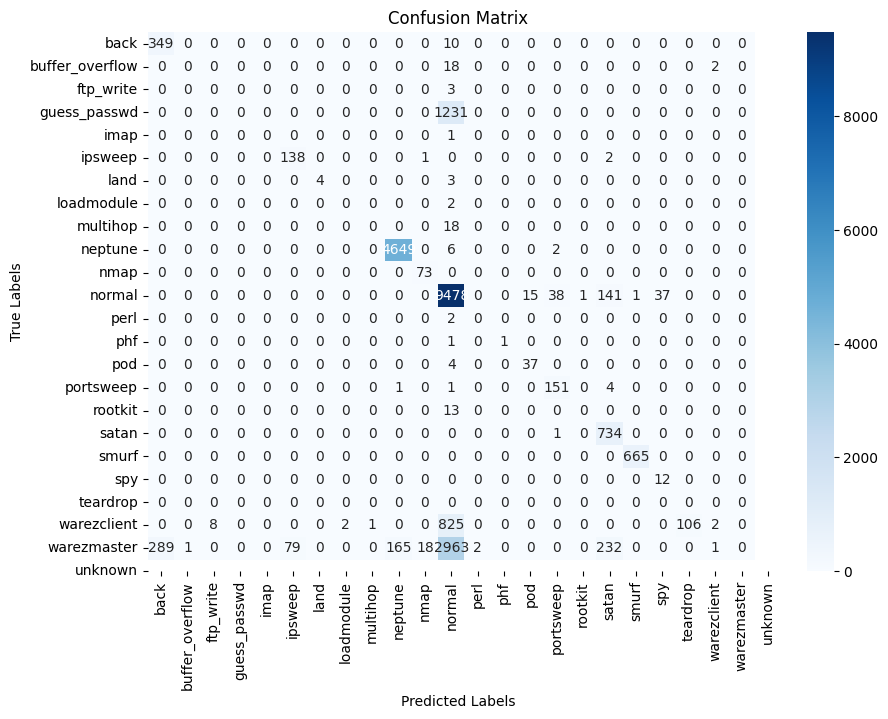

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


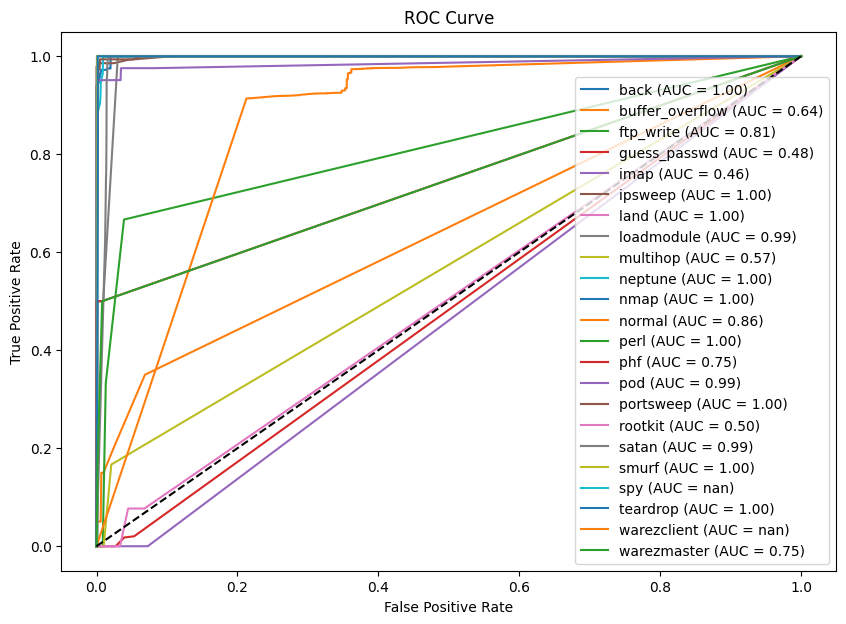

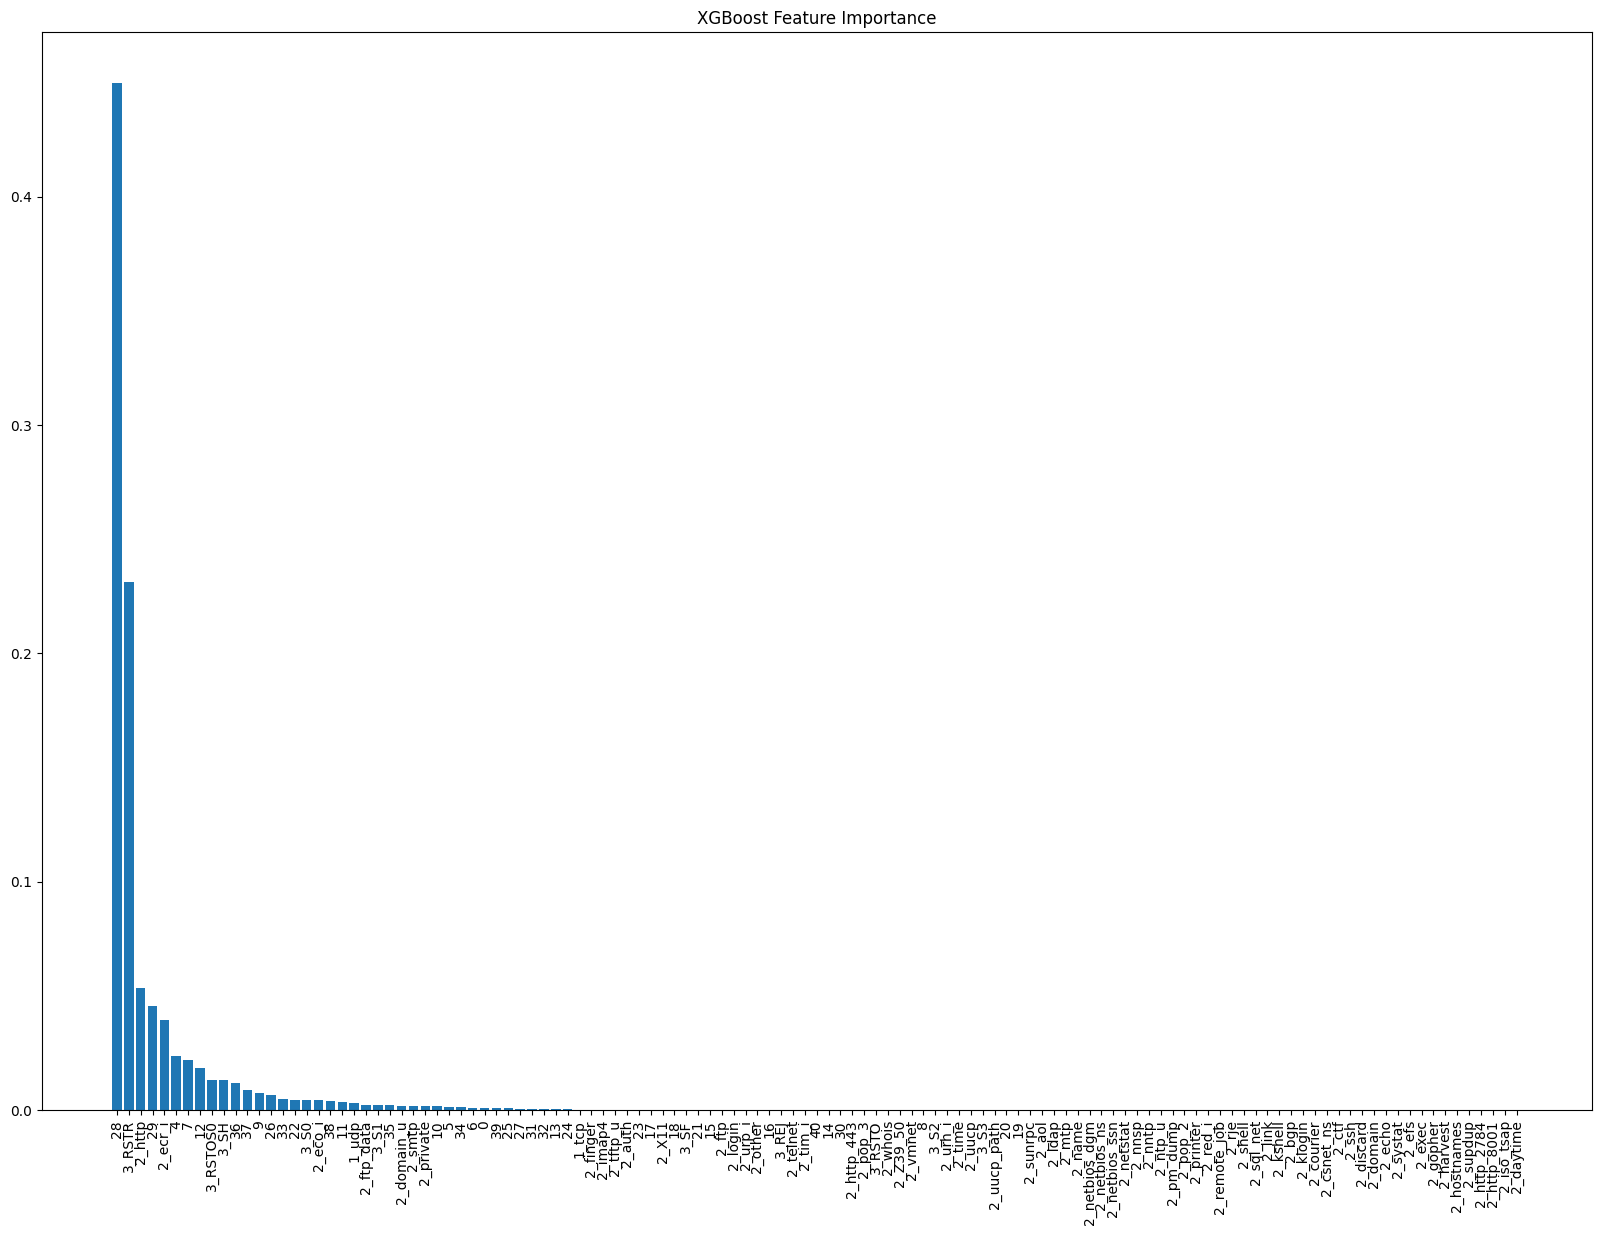

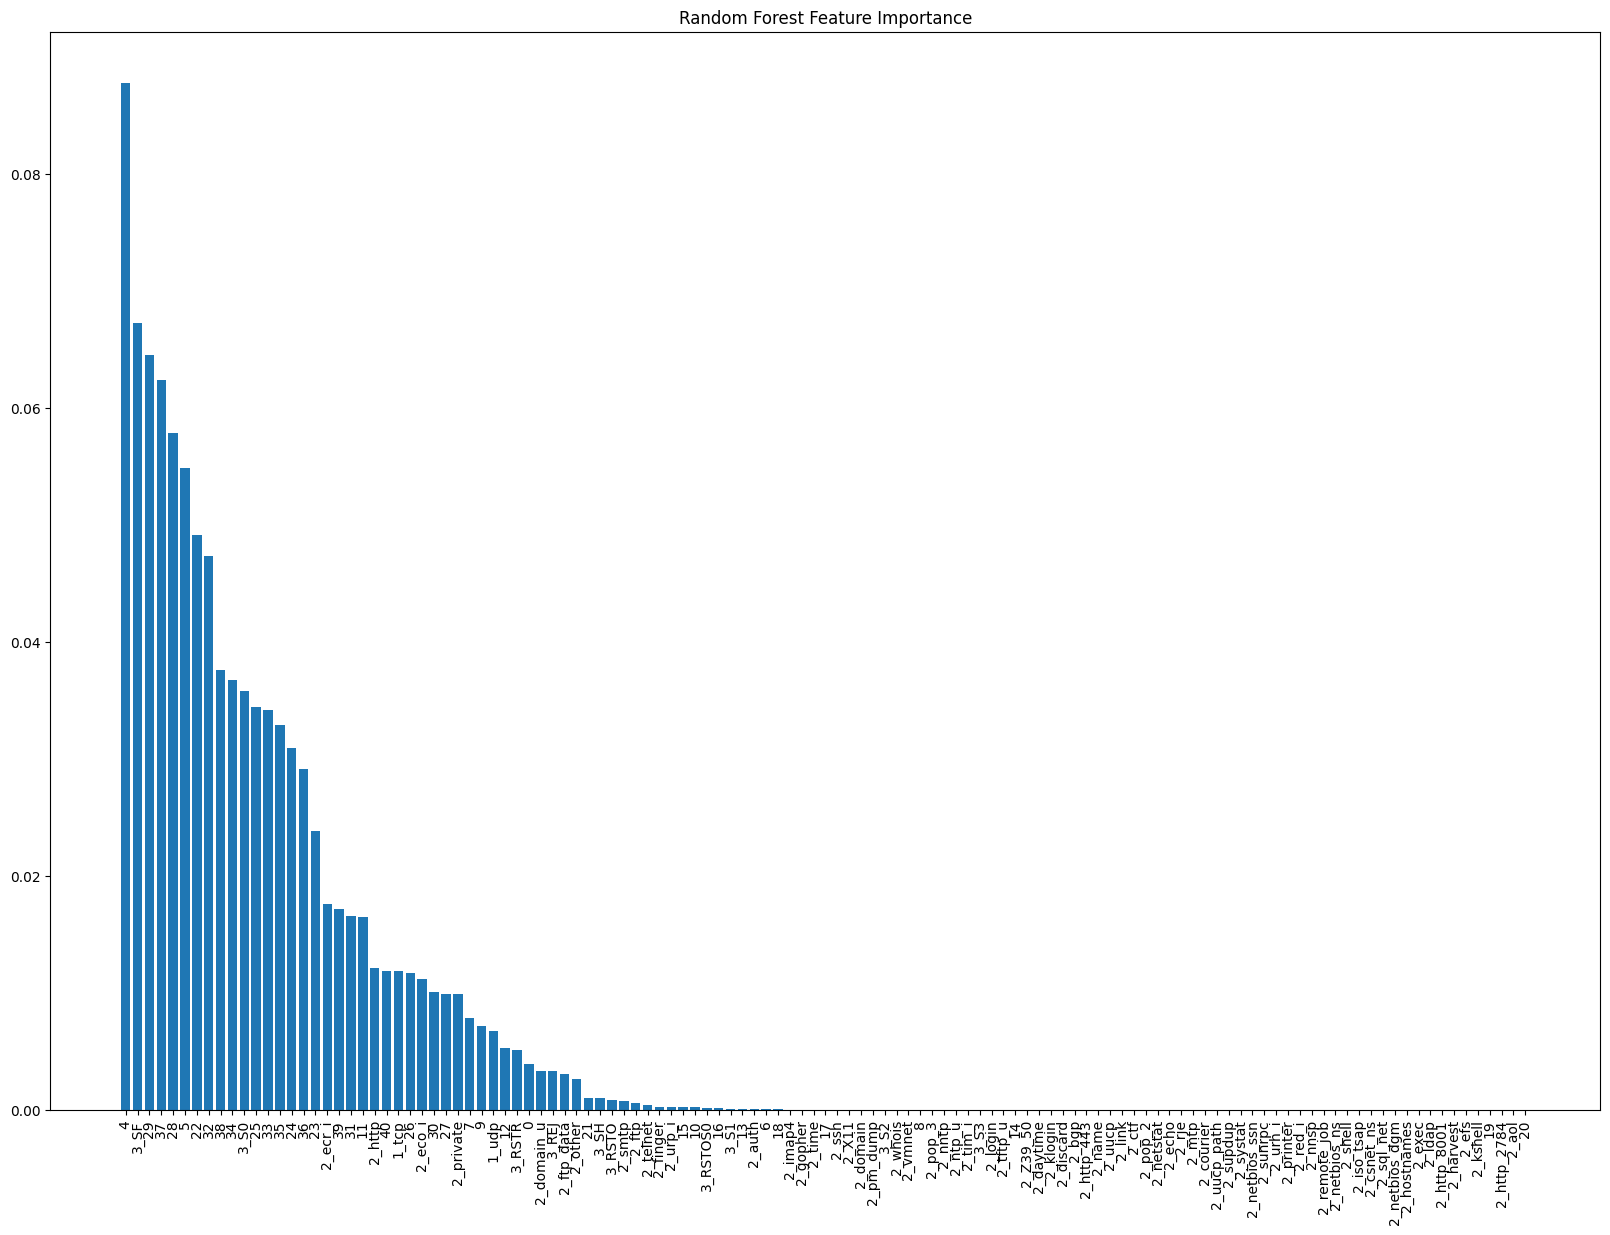

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.99841238 0.99845207 0.99857115 0.99837263 0.99845201]
Mean Accuracy: 0.9985
Standard Deviation: 0.0001

Models saved successfully.


<Figure size 640x480 with 0 Axes>

In [11]:
# Step 9: Main workflow
def main():
    train_path = "/content/drive/MyDrive/IDS/NSL_KDD_Train.csv"
    test_path = "/content/drive/MyDrive/IDS/NSL_KDD_Test.csv"

    global X_train, y_train, X_test, y_test
    X_train, y_train, X_test, y_test = load_data(train_path, test_path)

    # Train individual models
    cnn_lstm_model = train_cnn_lstm(X_train, y_train, X_test, y_test, num_classes=len(np.unique(y_train)))

    rf_model = train_random_forest(X_train, y_train, X_test, y_test)
    xgb_model = train_xgboost(X_train, y_train, X_test, y_test)

    # Stacking ensemble
    stacked_model = stacked_ensemble(
        models=[cnn_lstm_model, rf_model, xgb_model],
        X_meta=X_train,
        y_meta=y_train,
        X_test=X_test,
        y_test=y_test
    )
    # Model evaluation
    final_preds = stacked_model.predict(test_meta_features)
    evaluate_model(y_test, final_preds, class_names)

    # ROC Curve and AUC
    y_pred_proba = stacked_model.predict_proba(test_meta_features)
    plot_roc_curve(y_test, y_pred_proba, class_names)

    # Feature Importance
    plot_feature_importance(xgb_model, X_train_columns, title="XGBoost Feature Importance")
    plot_feature_importance(rf_model, X_train_columns, title="Random Forest Feature Importance")

    # Cross-Validation
    cross_validate_model(stacked_model, X_train, y_train, cv=5)

    # Saving model
    save_model(cnn_lstm_model.state_dict(), rf_model, xgb_model, stacked_model)

    # Save confusion matrix
    plt.savefig('/content/drive/MyDrive/IDS/confusion_matrix.png')


if __name__ == "__main__":
    main()

In [ ]:
# Load CNN-LSTM
cnn_lstm_loaded = CNNLSTM(input_dim=X_train.shape[1], num_classes=len(np.unique(y_train)))
cnn_lstm_loaded.load_state_dict(torch.load("/content/drive/MyDrive/IDS_Models/cnn_lstm_model.pth"))
cnn_lstm_loaded.eval()

# Load Random Forest and XGBoost models
rf_loaded = joblib.load("/content/drive/MyDrive/IDS_Models/random_forest_model.pkl")
xgb_loaded = joblib.load("/content/drive/MyDrive/IDS_Models/xgboost_model.pkl")

# Load the stacked meta-classifier
stacked_loaded = joblib.load("/content/drive/MyDrive/IDS_Models/stacked_meta_classifier.pkl")


<ipython-input-13-d25a01024798>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_lstm_loaded.load_state_dict(torch.load("/content/drive/MyDrive/IDS_Models/cnn_lstm_model